# Import Library

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import date, timedelta
import requests
import io
%matplotlib inline

# Preprocess Data

In [206]:
# Fetching Live Data from CSSE 
url_confirm="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s_confirm = requests.get(url_confirm).content
s_death = requests.get(url_death).content
confirmed_df = pd.read_csv(io.StringIO(s_confirm.decode('utf-8')))
deaths_df = pd.read_csv(io.StringIO(s_death.decode('utf-8')))

In [207]:
confirmed_df.rename(columns={"Admin2": "County"}, inplace=True)
deaths_df.rename(columns={"Admin2": "County"}, inplace=True)

In [305]:
confirmed_df.head()

,UID,iso2,iso3,code3,FIPS,County,Province_State,Country_Region,Lat,Long_,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,93,112,113,121,121,128,130,133,133,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,452,475,513,573,620,683,725,788,897,903
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,40,42,43,43,45,45,50,51,51,51


### Get the Latest Date

In [209]:
latest_date = (date.today()).strftime("%#m/%d/%y")
print(latest_date)

4/13/20


## Examining Growth Rates State-by-State

In [210]:
def avg_growth_rate_last_n_days(df, n_days):
    last_n_days = df.values[:, -n_days:]
    try:
        last_n_days = last_n_days.astype("int")
    except:
        raise Exception("Incorrectly specified number of days")
    
    delta_list = []
    for i in range(n_days-1):
        delta = (last_n_days[:,i+1] - last_n_days[:,i]) / np.maximum(last_n_days[:,i], 1)
        delta_list.append(delta)
    
    return np.mean(delta_list, axis=0)

#### California 

In [211]:
CA_df = confirmed_df.loc[confirmed_df['Province_State'] == "California"].copy()
ca_growth_last_3_days = avg_growth_rate_last_n_days(CA_df, 3)

CA_df["Location"] = "S"
CA_df.loc[CA_df["Lat"] > 36, "Location"] = "N"

CA_df['ROC'] = ca_growth_last_3_days

sorted_by_severity = CA_df.sort_values(by=["ROC"], ascending=False)
thresh = 20
sorted_by_severity.loc[sorted_by_severity[latest_date] > thresh, ["County", "ROC", "Location"]].head(10)

,County,ROC,Location
244,Tulare,0.140611,N
247,Yolo,0.115076,N
205,Kern,0.084198,S
229,San Joaquin,0.068262,N
234,Santa Cruz,0.067045,N
223,Riverside,0.065688,S
224,Sacramento,0.063978,N
240,Stanislaus,0.062874,N
233,Santa Clara,0.059557,N
228,San Francisco,0.057490,N


In [212]:
CA_deaths_df = deaths_df.loc[deaths_df['Province_State'] == "California"].copy()

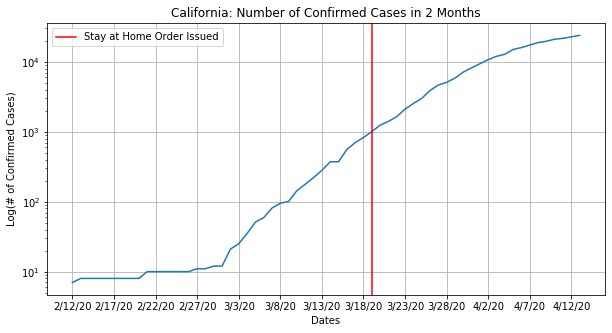

In [213]:
fig, ax = plt.subplots(1, figsize = (10,5))
ax.grid()
ax.set_xlabel('Dates')
ax.set_ylabel('Log(# of Confirmed Cases)')
ax.set_title('California: Number of Confirmed Cases in 2 Months')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_yscale('log')
ax.plot(CA_df.loc[:, '2/12/20': latest_date].sum())
ax.axvline(x = '3/19/20', color = 'red', label = 'Stay at Home Order Issued')
ax.legend()

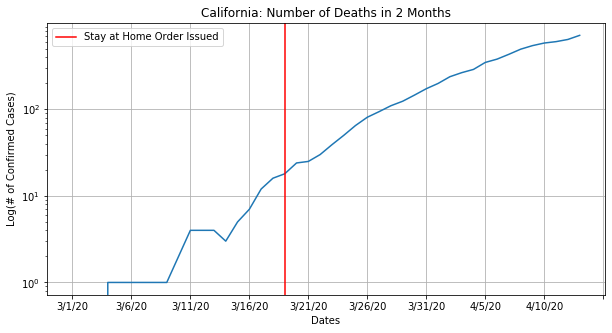

In [214]:
fig, ax = plt.subplots(1, figsize = (10,5))
ax.grid()
ax.set_xlabel('Dates')
ax.set_ylabel('Log(# of Confirmed Cases)')
ax.set_title('California: Number of Deaths in 2 Months')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_yscale('log')
ax.plot(CA_deaths_df.loc[:, '3/1/20': latest_date].sum())
ax.axvline(x = '3/19/20', color = 'red', label = 'Stay at Home Order Issued')
ax.legend()

<BarContainer object of 60 artists>

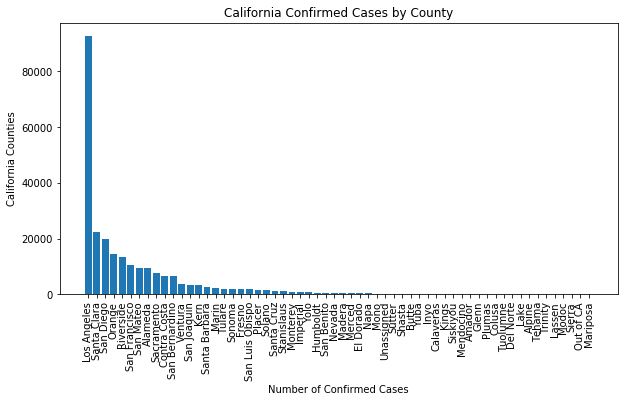

In [302]:
CA_df_county = CA_df.loc[:,'County': latest_date].drop(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], 1)
CA_df_county['Total Cases']= CA_df_county.iloc[:, -(CA_df_county.columns.get_loc(latest_date) + 1) : -1].sum(axis=1)
CA_df_county = CA_df_county.sort_values(by=['Total Cases'], ascending = False)

fig, ax = plt.subplots(1, figsize = (10,5))
ax.set_title('California Confirmed Cases by County')
ax.set_xlabel('Number of Confirmed Cases')
ax.set_ylabel('California Counties')
plt.xticks(rotation='vertical')
plt.bar(CA_df_county['County'], CA_df_county['Total Cases'])

#### New York

In [215]:
NY_df = confirmed_df.loc[confirmed_df['Province_State'] == "New York"].copy()
NY_growth_last_3_days = avg_growth_rate_last_n_days(NY_df, 3)

# NY_df["Location"] = "S"
# NY_df.loc[NY_df["Lat"] > 36, "Location"] = "N"

NY_df['ROC'] = NY_growth_last_3_days

sorted_by_severity_ny = NY_df.sort_values(by=["ROC"], ascending=False)
thresh = 20
sorted_by_severity_ny.loc[sorted_by_severity_ny[latest_date] > thresh, ["County", "ROC"]].head(10)

,County,ROC
1837,Cattaraugus,0.236842
1883,Steuben,0.128205
1844,Cortland,0.117647
1852,Greene,0.105958
1886,Tioga,0.105263
1888,Ulster,0.102592
1890,Washington,0.092505
1864,Niagara,0.080838
1868,Orange,0.075362
1866,Onondaga,0.067982


In [216]:
NY_deaths_df = deaths_df.loc[deaths_df['Province_State'] == "New York"].copy()

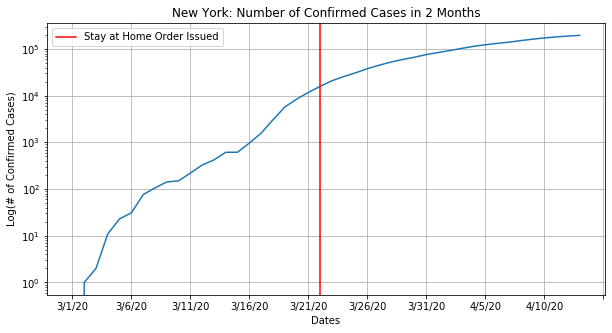

In [217]:
fig, ax = plt.subplots(1, figsize = (10,5))
ax.grid()
ax.set_xlabel('Dates')
ax.set_ylabel('Log(# of Confirmed Cases)')
ax.set_title('New York: Number of Confirmed Cases in 2 Months')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_yscale('log')
ax.plot(NY_df.loc[:, '3/1/20': latest_date].sum())
ax.axvline(x = '3/22/20', color = 'red', label = 'Stay at Home Order Issued')
ax.legend()

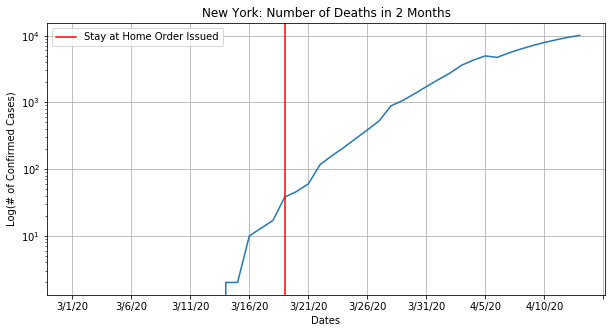

In [218]:
fig, ax = plt.subplots(1, figsize = (10,5))
ax.grid()
ax.set_xlabel('Dates')
ax.set_ylabel('Log(# of Confirmed Cases)')
ax.set_title('New York: Number of Deaths in 2 Months')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_yscale('log')
ax.plot(NY_deaths_df.loc[:, '3/1/20': latest_date].sum())
ax.axvline(x = '3/19/20', color = 'red', label = 'Stay at Home Order Issued')
ax.legend()

<BarContainer object of 64 artists>

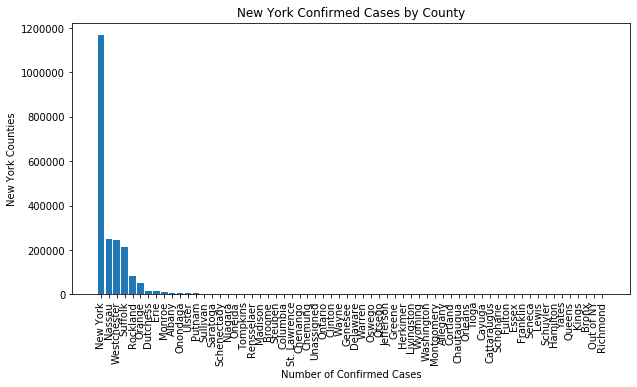

In [304]:
NY_df_county = NY_df.loc[:,'County': latest_date].drop(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], 1)
NY_df_county['Total Cases']= NY_df_county.iloc[:, -(NY_df_county.columns.get_loc(latest_date) + 1) : -1].sum(axis=1)
NY_df_county = NY_df_county.sort_values(by=['Total Cases'], ascending = False)

fig, ax = plt.subplots(1, figsize = (10,5))
ax.set_title('New York Confirmed Cases by County')
ax.set_xlabel('Number of Confirmed Cases')
ax.set_ylabel('New York Counties')
plt.xticks(rotation='vertical')
plt.bar(NY_df_county['County'], NY_df_county['Total Cases'])

###### New York City

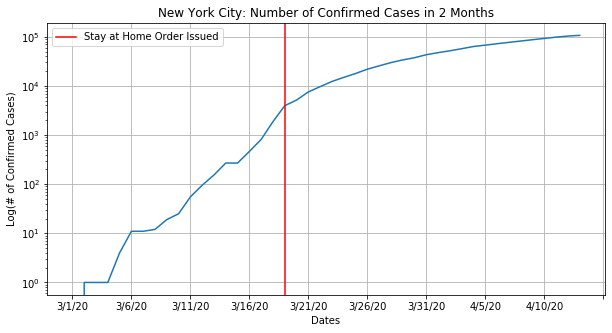

In [219]:
NYC_df = confirmed_df[confirmed_df['County'] == "New York"]
fig, ax = plt.subplots(1, figsize = (10,5))
ax.grid()
ax.set_xlabel('Dates')
ax.set_ylabel('Log(# of Confirmed Cases)')
ax.set_title('New York City: Number of Confirmed Cases in 2 Months')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_yscale('log')
ax.plot(NYC_df.loc[:, '3/1/20': latest_date].sum())
ax.axvline(x = '3/19/20', color = 'red', label = 'Stay at Home Order Issued')
ax.legend()